In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from datasets.fashion_mnist import FashionMNISTDataset
from mixer.mixer import SetMixer

from notebooks.mnist_classifier.mnist_tiny_cnn import TinyCNN

from itertools import product
import scipy as sp
from scipy.linalg import sqrtm

from torchvision import models, transforms
from geomloss import SamplesLoss

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [3]:
device = 'cuda'
configs = get_all_experiments_info('/orcd/data/omarabu/001/gokul/DistributionEmbeddings/outputs/', False)
cfg = [c for c in configs if 'fmnist_sys' in c['name']]

classy = TinyCNN()
classy.load_state_dict(torch.load('notebooks/mnist_classifier/fmnist_tinycnn.pth'))
classy.to('cuda')

# load model and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

print([(i, c['encoder'], c['generator']) for i, c in enumerate(cfg)])

[(0, 'ConvDistributionEncoder', 'DDPM'), (1, 'KMEEncoder', 'DDPM'), (2, 'WormholeEncoder', 'WormholeGenerator')]


In [4]:
dataset = hydra.utils.instantiate(cfg[0]['config']['dataset'])
mixer = hydra.utils.instantiate(cfg[0]['config']['mixer'])

dataloader = DataLoader(dataset, batch_size=8, 
                        shuffle=True, collate_fn=mixer.collate_fn)


ConvDistributionEncoder DDPM


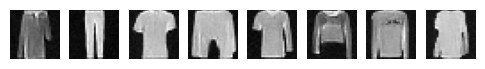

KMEEncoder DDPM


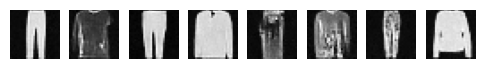

WormholeEncoder WormholeGenerator


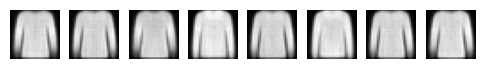

In [5]:
for idx in [0, 1, 2]:
    enc, gen = load_model(cfg[idx]['config'], cfg[idx]['dir'], 'cuda')

    print(cfg[idx]['encoder'], cfg[idx]['generator'])

    for idx, batch in enumerate(dataloader):
        # fig, axs = plt.subplots(1, len(batch['samples']), figsize=(6, 1))
        # print(batch['metadata'])
        # for i in range(len(batch['samples'])):
        #     axs[i].imshow(batch['samples'][i][0].reshape(28, 28), cmap='gray')
        #     axs[i].axis('off')
        # plt.show()

        with torch.no_grad():
            x = batch['samples'].to('cuda')
            z = enc(x)
            x_hat = gen.sample(z, num_samples=1)
        fig, axs = plt.subplots(1, len(batch['samples']), figsize=(6, 1))
        for i in range(len(batch['samples'])):
            axs[i].imshow(x_hat.cpu().numpy()[i][0].reshape(28, 28), cmap='gray')
            axs[i].axis('off')
        plt.show()
        
        if idx > -1:
            break

In [25]:
set_size = 128

d = {
    "Encoder" : [],
    "Generator" : [],
    "OT reconstruction error" : [],}

pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = torch.nn.Identity()  # remove the classification head
pretrained_model.eval().to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to match the input size of the model
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize Sinkhorn divergence loss
sinkhorn_loss = SamplesLoss("sinkhorn")

# Modify the loop to compute Sinkhorn divergence
for c in tqdm(cfg):
    encoder_name = c['encoder']
    generator_name = c['generator']

    if generator_name == 'DirectGenerator':
        generator_name += '-' + c['config']['generator']['loss_type']

    try:
        enc, gen = load_model(c['config'], c['dir'], device=device)
    except:
        print("broken: ", encoder_name, generator_name)
        continue

    sinkhorn_divs = []

    for idx, batch in enumerate(dataloader):
        with torch.no_grad():
            x = batch['samples'].to(device)  #  (batch, set_size, 1, 28, 28)
            z = enc(x)

            gen.loss(x.view(-1, *x.shape[2:]), z)
            x_hat = gen.sample(z, num_samples=100).to(device)  

            # process each set in the batch independently
            for i in range(x.shape[0]): 
                true_images = x[i]  # (set_size, 1, 28, 28)
                generated_images = x_hat[i] 

                # convert 1-channel images to 3-channel
                true_images = true_images.repeat(1, 3, 1, 1)  # Shape: (set_size, 3, 28, 28)
                generated_images = generated_images.repeat(1, 3, 1, 1)  # Shape: (set_size, 3, 28, 28)

                true_images_transformed = transform(true_images)  # Shape: (set_size, 3, 224, 224)
                generated_images_transformed = transform(generated_images)  # Shape: (set_size, 3, 224, 224)

                # extract representations
                true_repr = pretrained_model(true_images_transformed)  # Shape: (set_size, feature_dim)
                generated_repr = pretrained_model(generated_images_transformed)  # Shape: (set_size, feature_dim)

                # compute Sinkhorn divergence
                sinkhorn_div = sinkhorn_loss(true_repr, generated_repr)
                sinkhorn_divs.append(sinkhorn_div.item())

        if idx > 1:  
            break

    print(f"Encoder: {encoder_name}, Generator: {generator_name}, Sinkhorn Divergence: {np.mean(sinkhorn_divs)}")

    d["Encoder"].append(encoder_name)
    d["Generator"].append(generator_name)
    d["OT reconstruction error"].append(np.mean(sinkhorn_divs))

/orcd/home/002/gokulg/miniforge3/envs/distemb/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/orcd/home/002/gokulg/miniforge3/envs/distemb/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/3 [00:00<?, ?it/s]

Encoder: ConvDistributionEncoder, Generator: DDPM, Sinkhorn Divergence: 102.2151050567627
Encoder: KMEEncoder, Generator: DDPM, Sinkhorn Divergence: 111.01105658213298
Encoder: WormholeEncoder, Generator: WormholeGenerator, Sinkhorn Divergence: 320.1865628560384


In [8]:
pd.DataFrame(d)#.sort_values(by="OT reconstruction error")

,Encoder,Generator,OT reconstruction error
0,ConvDistributionEncoder,DDPM,102.215105
1,KMEEncoder,DDPM,111.011057
2,WormholeEncoder,WormholeGenerator,320.186563
